In [10]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import geom

N_BINS = 8
LAMBDA = 0.8

In [2]:
def expo_seq_angles(n_bins: int, lambda_rate: float):
    """
    Calculates the individual peg rotation angles needed to produce a sequential
    geometric/exponential distribution.

    Args:
        n_bins: The number of output bins.
        lambda_rate: The decay rate (lambda) of the exponential distribution.

    Returns:
        A list of theta angles for the Ry gates and the theoretical probabilities.
    """

    bins = np.arange(n_bins)
    
    # probability of stopping is p = 1 - e^(-lambda)
    p_stop = 1 - np.exp(-lambda_rate)
    target_probs = geom.pmf(bins + 1, p_stop)
    
    # because of finite number bins, the last bin must contain all remaining probability
    target_probs[-1] = 1.0 - np.sum(target_probs[:-1])
    target_probs /= np.sum(target_probs)

    peg_probs = []
    remaining_prob = 1.0
    for k in range(n_bins):
        # conditional probability of the k-th peg firing is P(k) / P(not firing before)
        p_k = target_probs[k] / remaining_prob if remaining_prob > 1e-9 else 1.0
        p_k = max(0, min(1, p_k)) # clamp probability between 0 and 1
        peg_probs.append(p_k)
        remaining_prob -= target_probs[k]

    # Ry rotation angles: p = sin^2(theta/2)
    peg_angles = [2 * np.arcsin(np.sqrt(p)) for p in peg_probs]
    
    return peg_angles, target_probs

In [3]:
def seq_qgb(n_bins: int, angles: list):
    """
    Builds a QGB that models a sequential decision process.

    Args:
        n_bins: The number of qubits (and output bins).
        angles: A list of Ry angles, one for each peg.

    Returns:
        The complete QuantumCircuit.
    """
    anc = QuantumRegister(1, name='ancilla')
    bins = QuantumRegister(n_bins, name='bins')
    creg = ClassicalRegister(n_bins, name='c')
    qc = QuantumCircuit(anc, bins, creg)

    # ancilla starts as |1> (ball falling)
    qc.x(anc[0])
    qc.barrier()

    for i in range(n_bins):
        # if ancilla is |1>, apply the rotation to the current bin qubit
        qc.cry(angles[i], anc[0], bins[i])
        
        # if bin qubit is now |1> (ball caught), flip ancilla to |0>
        # stops subsequent CRY gates from activating
        qc.cx(bins[i], anc[0])
        
    qc.measure(bins, creg)
    return qc

In [11]:
def run(n_bins=N_BINS, shots=8192, lambda_rate=LAMBDA):
    """
    Runs the full simulation of the QGB.
    
    Returns:
        qc: The quantum circuit.
        sim_probs: The simulated probabilities given by the circuit.
        theoretical_probs: The theoretical "expected" probabilities.
    """
    angles, theoretical_probs = expo_seq_angles(n_bins, lambda_rate)
    
    qc = seq_qgb(n_bins, angles)
    
    # simulation
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()
    
    # post-process
    bin_counts = Counter()
    total_shots = 0
    for bitstring, count in counts.items():
        if bitstring.count('1') <= 1:
            total_shots += count
            if '1' in bitstring:
                # The bin is the index of the '1'
                bin_index = bitstring[::-1].index('1')
                bin_counts[bin_index] += count
    
    sim_probs = {k: v / total_shots for k, v in bin_counts.items()}

    return qc, sim_probs, theoretical_probs

qc, sim_probs, theoretical_probs = run()

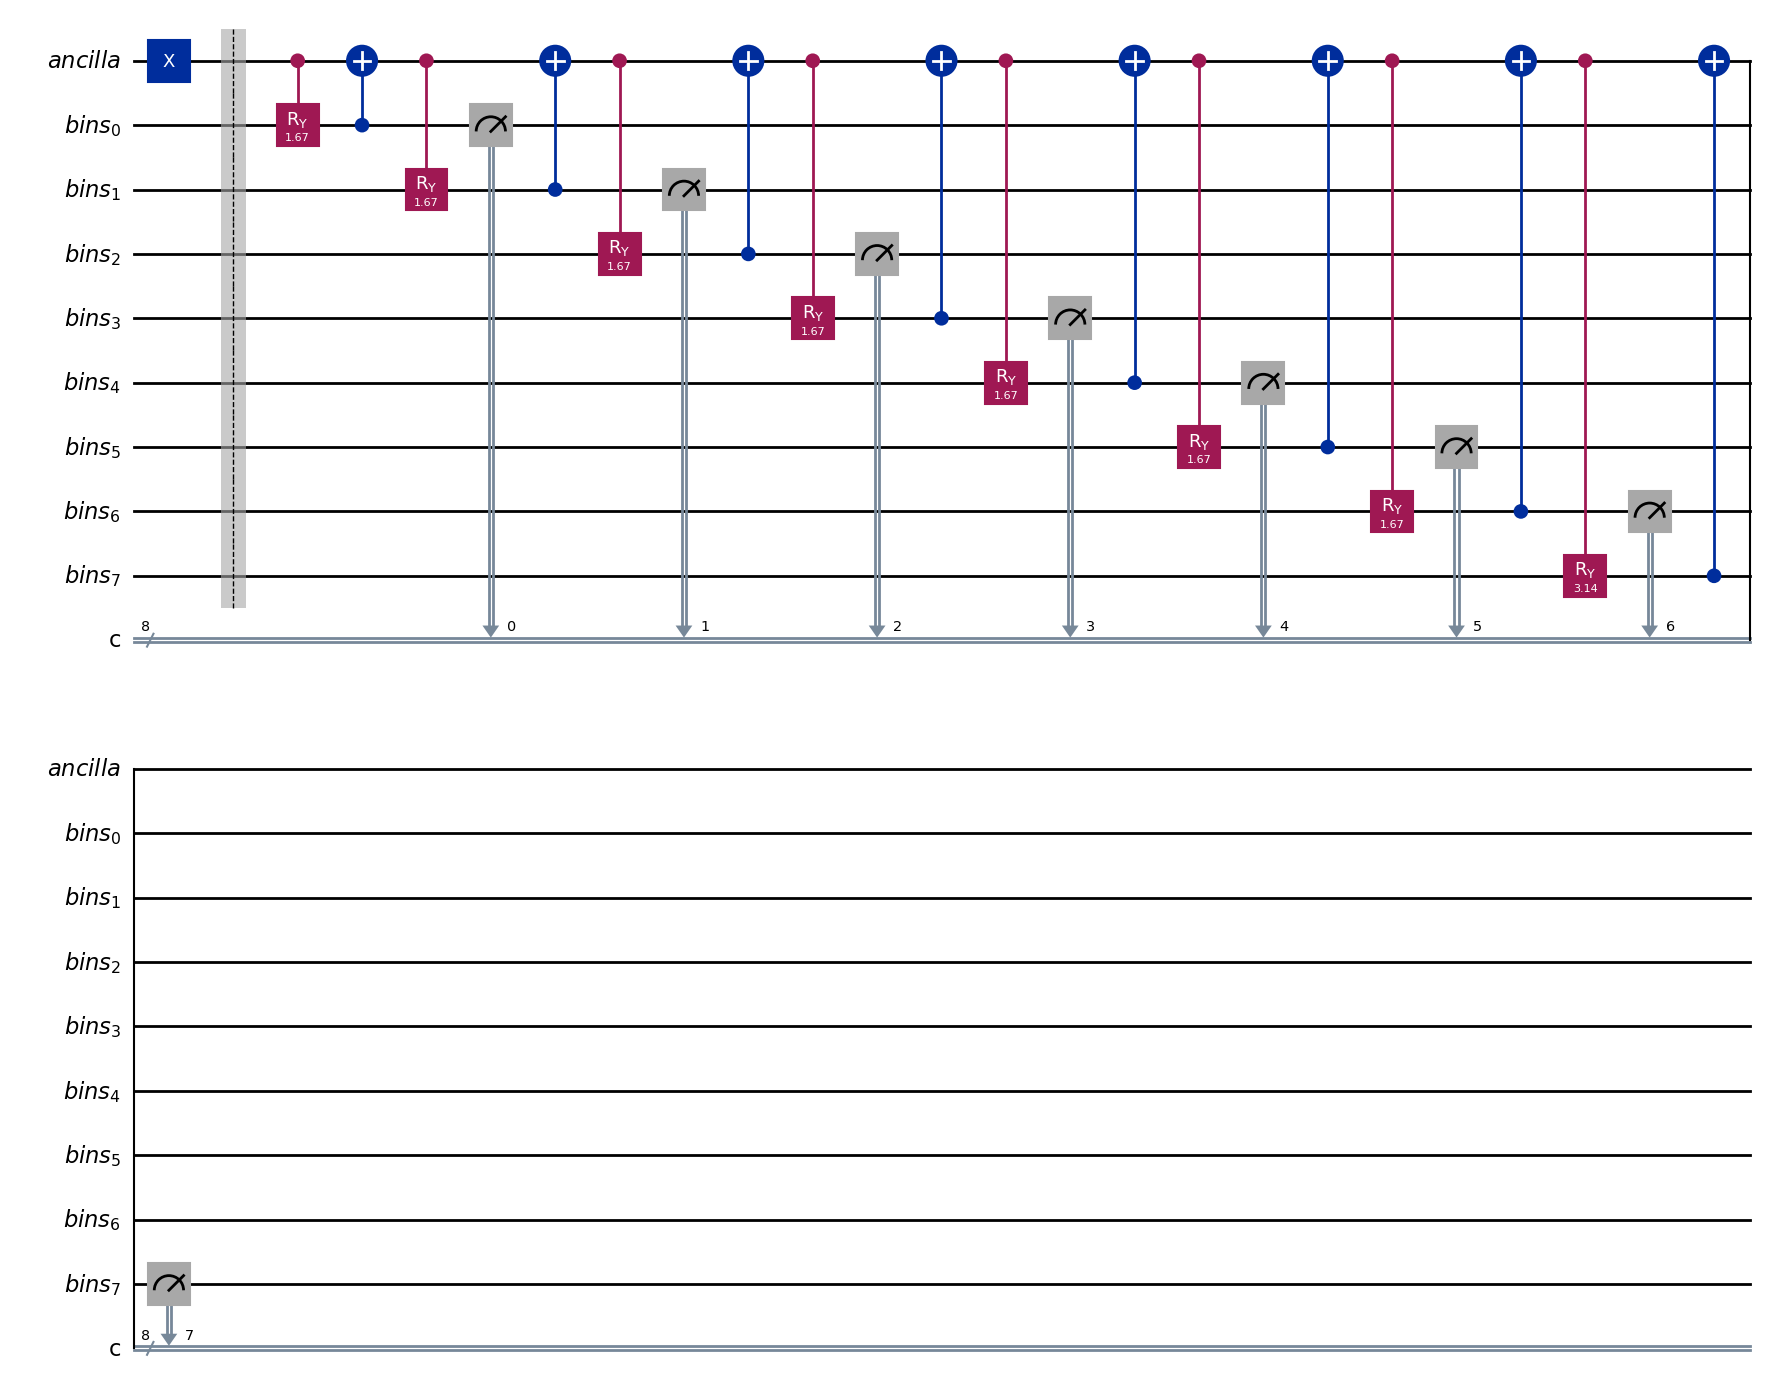

In [12]:
qc.draw('mpl')

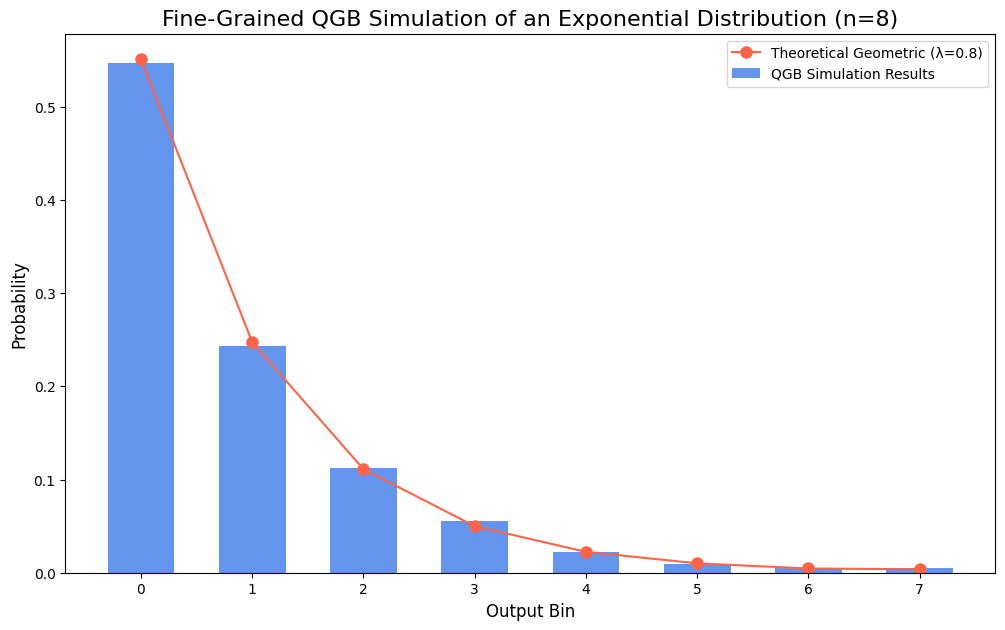

In [13]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.bar(sim_probs.keys(), sim_probs.values(), color='cornflowerblue', label='QGB Simulation Results', width=0.6)

ax.plot(np.arange(N_BINS), theoretical_probs, 'o-', color='tomato', markersize=8, label=f'Theoretical Geometric (λ={LAMBDA})')

ax.set_title(f'Fine-Grained QGB Simulation of an Exponential Distribution (n={N_BINS})', fontsize=16)
ax.set_xlabel('Output Bin', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.legend()
ax.set_xticks(np.arange(N_BINS))
plt.show()